In [39]:
%load_ext autoreload
%autoreload 2

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [311]:
import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, PyTree
print("Default backend:", jax.default_backend())


Default backend: cpu


In [41]:
jax.devices()

[CpuDevice(id=0)]

In [42]:
import equinox as eqx

In [5]:
from neuralop.models import FNO


In [6]:
from neuralop.data.datasets import load_darcy_flow_small


In [7]:
data_dir = '/Users/alexszen/Desktop/github/neuraloperator/neuralop/data/datasets/data'

train_loader, test_loaders, data_processor = load_darcy_flow_small(data_root=data_dir,
        n_train=100, batch_size=4, 
        test_resolutions=[16, 32], n_tests=[50, 50], test_batch_sizes=[4, 2],
        )

train_dataset = train_loader.dataset

Loading test db for resolution 16 with 50 samples 
Loading test db for resolution 32 with 50 samples 


In [7]:
train_dataset[0]['x'].shape

torch.Size([1, 16, 16])

In [8]:
import matplotlib.pyplot as plt 

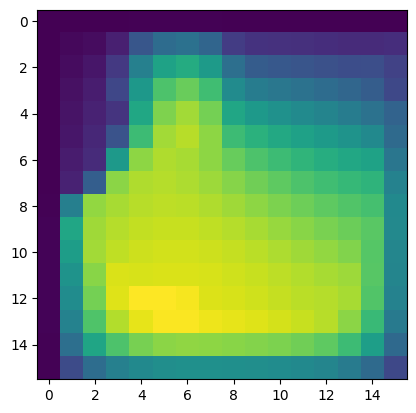

In [9]:
plt.imshow(train_dataset[0]['y'][0])

In [8]:
test_x = train_dataset[0]['x'].numpy()

In [9]:
test_x_with_c = jnp.expand_dims(test_x, axis=0)

In [10]:
test_x_with_c.shape

(1, 1, 16, 16)

In [11]:
test = jnp.fft.fft2(test_x_with_c)

In [12]:
test.shape

(1, 1, 16, 16)

In [13]:
modes = 12

In [14]:
test_cropped = test[:,:,:modes,:modes]

In [15]:
test_cropped.shape

(1, 1, 12, 12)

In [16]:
h_crop = jnp.arange(modes)

In [32]:
h_crop[:,None]

(12, 1)

In [64]:
seed = 0
key = jax.random.key(seed)

In [44]:
from equinox.nn._misc import default_init
from equinox._module import field

In [103]:
class SpectralConv2D(eqx.Module):
    real_weights: jax.Array
    img_weights: jax.Array
    real_bias: jax.Array
    img_bias: jax.Array
    in_channels: int = eqx.field(static=True)
    out_channels: int = eqx.field(static=True)
    modes: int = eqx.field(static=True)
    use_bias: bool = eqx.field(static=True)


    def __init__(self, in_channels, out_channels, modes, key, use_bias=True):

        self.in_channels = in_channels
        self.out_channels = out_channels 
        self.modes = modes 
        self.use_bias = use_bias
        keys = jax.random.split(key, 4)
        scale = 2 / (in_channels + out_channels) ** 2
        self.real_weights = jax.random.normal(keys[0], (out_channels, in_channels, modes, modes)) * scale
        self.img_weights = jax.random.normal(keys[0], (out_channels, in_channels, modes, modes)) * scale
        self.real_bias = jnp.zeros((out_channels)) if use_bias else None
        self.img_bias = jnp.zeros((out_channels)) if use_bias else None

    def __call__(self, x: jax.Array):

        c, h, w = x.shape
        assert c == self.in_channels, f'Input channels must match in_channels, got {c} != {self.in_channels}'
        out_ft_real = jnp.zeros((self.out_channels, h, w))
        out_ft_imag = jnp.zeros((self.out_channels, h, w))
        x_ft = jnp.fft.fft2(x)
        x_ft_real_crop = jnp.real(x_ft)[:, :self.modes, :self.modes]
        x_ft_img_crop = jnp.imag(x_ft)[:, :self.modes, :self.modes]
        out_real_crop = (x_ft_real_crop * self.real_weights - x_ft_img_crop * self.img_weights).sum(axis=1)
        out_img_crop = (x_ft_real_crop * self.img_weights + x_ft_img_crop * self.real_weights).sum(axis=1)
        out_ft_real = out_ft_real.at[:, :self.modes, :self.modes].set(out_real_crop)
        out_ft_imag = out_ft_imag.at[:, :self.modes, :self.modes].set(out_img_crop)
        out = jnp.fft.ifft2(out_ft_real + 1j * out_ft_imag)
        return jnp.real(out)

        

        

        
        

        
                                   
        
        
    

In [80]:
in_c = 12
out_c = 24
h = 16
w = 16
modes = 12

In [86]:
test_in = jnp.zeros((in_c, h, w))
weights = jnp.zeros((out_c, in_c, h, w))

In [52]:
test = test_in * weights

In [53]:
test_summed = jnp.sum(test, axis = 1)

(24, 12, 16, 16)

In [104]:
key, subkey = jax.random.split(key)
testconv = SpectralConv2D(in_c, out_c, modes, subkey)

In [105]:
testout = testconv(test_in)

In [106]:
testout.shape

(24, 16, 16)

In [101]:
# spectral_conv.py
from __future__ import annotations
from typing import Sequence, Tuple, Optional

import jax
import jax.numpy as jnp
import equinox as eqx


def _central_crop_slices(
    fft_shape: Sequence[int],        # e.g. (Hx, Hy, Hz//2+1)
    n_modes: Sequence[int]           # same length as fft_shape
) -> Tuple[slice, ...]:
    """
    Build slice objects that pick the centred block of size n_modes[:-1]
    in the shifted spectrum, and the first n_modes[-1] coefficients on
    the rFFT axis (no shift there).
    """
    *shifted_axes, last_axis = fft_shape
    *modes_shifted, modes_last = n_modes

    # axes that were fft‑shifted (all except the rFFT axis)
    slices = []
    for size, k in zip(shifted_axes, modes_shifted):
        centre = size // 2
        neg = k // 2
        pos = k - neg          # keeps k elements
        slices.append(slice(centre - neg, centre + pos))

    # rFFT axis → take the low‑frequency part only
    slices.append(slice(0, modes_last))
    return tuple(slices)


class SpectralConv(eqx.Module):
    """Equinox implementation of the plain (dense) FNO spectral convolution."""
    weight: jax.Array                      # (in_c, out_c, *n_modes)
    bias:   Optional[jax.Array] = None     # (out_c, 1, …, 1)

    n_modes: Tuple[int, ...] = eqx.static_field()
    in_channels:  int  = eqx.static_field()
    out_channels: int  = eqx.static_field()
    fft_norm: str = eqx.static_field()

    # --------------------------------------------------------------------- #
    # constructor                                                           #
    # --------------------------------------------------------------------- #
    def __init__(
        self,
        key: jax.random.KeyArray,
        in_channels: int,
        out_channels: int,
        n_modes: Sequence[int],
        *,
        bias: bool = True,
        init_std: float | str = "auto",
        fft_norm: str = "forward",
    ):
        """
        Parameters
        ----------
        key          : PRNG key for weight/bias init
        in_channels  : C_in
        out_channels : C_out
        n_modes      : number of modes kept on each spatial axis
                       (note: the last entry counts rFFT coefficients)
        bias         : add a channel‑wise bias after the inverse FFT
        init_std     : std‐dev for weight init.  'auto' = He like in FNO.
        fft_norm     : 'forward' (like original code) or any jnp.fft option
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_modes = tuple(int(m) for m in n_modes)
        self.fft_norm = fft_norm

        if init_std == "auto":
            init_std = (2 / (in_channels + out_channels)) ** 0.5

        key_w, key_b = jax.random.split(key)
        w_shape = (in_channels, out_channels, *self.n_modes)
        # complex weight, iid N(0,σ²) on both real & imag parts
        self.weight = (
            init_std
            * (jax.random.normal(key_w, w_shape) + 1j * jax.random.normal(key_w, w_shape))
        ).astype(jnp.complex64)

        if bias:
            # shape: (C_out, 1, 1, …)
            b_shape = (out_channels,) + (1,) * len(self.n_modes)
            self.bias = init_std * jax.random.normal(key_b, b_shape)
        else:
            self.bias = None

    # --------------------------------------------------------------------- #
    # forward                                                               #
    # --------------------------------------------------------------------- #
    def __call__(self, x: jax.Array) -> jax.Array:  # (B, C_in, *spatial)
        """
        Parameters
        ----------
        x : real valued tensor of shape (batch, in_channels, d1, …, dN)

        Returns
        -------
        y : real tensor of shape (batch, out_channels, d1, …, dN)
        """
        batch, cin, *spatial = x.shape
        assert cin == self.in_channels, "channel mismatch"

        fft_axes = tuple(range(-len(spatial), 0))            # last N axes
        x_ft = jnp.fft.rfftn(x, axes=fft_axes, norm=self.fft_norm)          # → complex64
        if len(spatial) > 1:                                 # shift except rFFT axis
            x_ft = jnp.fft.fftshift(x_ft, axes=fft_axes[:-1])

        # build zero‑filled spectrum for the output
        out_ft = jnp.zeros(
            (batch, self.out_channels, *x_ft.shape[2:]),
            dtype=x_ft.dtype
        )

        # centred cropping
        crop_slices = _central_crop_slices(x_ft.shape[2:], self.n_modes)
        xs = (slice(None), slice(None), *crop_slices)        # for x_ft / out_ft
        ws = (slice(None), slice(None), *([slice(None)] * len(self.n_modes)))

        # contraction in Fourier domain
        out_crop = jnp.einsum(
            "b i ... , i o ... -> b o ...",                  # Einstein notation
            x_ft[xs], self.weight[ws]
        )
        out_ft = out_ft.at[xs].set(out_crop)

        # inverse shift & inverse FFT
        if len(spatial) > 1:
            out_ft = jnp.fft.ifftshift(out_ft, axes=fft_axes[:-1])

        y = jnp.fft.irfftn(out_ft, s=spatial, axes=fft_axes, norm=self.fft_norm)

        if self.bias is not None:
            y = y + self.bias

        return y.real                                         # ensure real output


In [105]:
import jax, jax.numpy as jnp, equinox as eqx
#from spectral_conv_opt_nb import SpectralConv

key = jax.random.PRNGKey(0)
conv = SpectralConv(key, in_channels=4, out_channels=8, n_modes=(16, 16))

in_c = 4
out_c = 8
h = 64
w = 64
x = jax.random.normal(key, (in_c, h, w))   # (Cin,H,W)
#y_single = conv(x_single)                        # (Cout,H,W)
                   # (B,Cout,H,W)


In [212]:
import jax, jax.numpy as jnp, equinox as eqx
#from spectral_conv_opt_nb import SpectralConv

key = jax.random.PRNGKey(0)
#conv = SpectralConv(key, in_channels=4, out_channels=8, n_modes=(16, 16))

in_c = 4
out_c = 8
h = 64
w = 64
n_modes = 9
x = jax.random.normal(key, (in_c, h, w))   # (Cin,H,W)
#y_single = conv(x_single)                        # (Cout,H,W)
                   # (B,Cout,H,W)


In [72]:
subkey, key = jax.random.split(key)

In [246]:
class SpectralConv:
    weights: jax.Array
    bias: Optional[jax.Array]
    in_channels:  int  = eqx.static_field()
    out_channels:  int  = eqx.static_field()
    n_modes:  int  = eqx.static_field()
    def __init__(self, in_channels, out_channels, n_modes, height, width, use_bias, key):
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_modes = n_modes
        self.use_bias = use_bias

        key_w, key_b = jax.random.split(subkey)

        # weights go from in_c to out_c, squares of size n_modes x n_modes
        w_shape = (in_c, out_c, 2*n_modes[0], n_modes[1])
        self.weight = jax.random.normal(key_w, w_shape) + 1j*jax.random.normal(key_w, w_shape)
        
        # one bias per output channel, broadcast along spatial dimensions.
        if use_bias:
            b_shape = (out_c,) + (1,) * len(spatial)
            self.bias = jnp.zeros(b_shape)
        
    def _build_slices(self, spatial):
        
        # Build slices for x: we grab n_modes x n_modes corners
        center_slice = spatial[0]//2
        start_slice = center_slice - self.n_modes[0]
        end_slice = center_slice + self.n_modes[0]
        x_slices = (slice(None), slice(start_slice, end_slice), slice(0, self.n_modes[1]))

    def __call__(self, x):
        
        _, *spatial = x.shape

        # do fft on spatial dimensions 
        fft_axes = tuple(range(-len(x.shape)+1, 0))
        x_ft = jnp.fft.fftshift(jnp.fft.rfftn(x, axes = fft_axes), axes=fft_axes[:-1])

        # create slices to grab corners of input
        slices = self._build_slices(spatial)

        # contract weight and corners of x over input channels.
        out_ft_crop = jnp.einsum("i...,io...->o...", x_ft[x_slices], w)
        
        # Create and fill output 
        out_ft = jnp.zeros((out_c, *x_ft.shape[1:]), dtype=x_ft.dtype)
        out_ft = out_ft.at[x_slices].set(out_ft_crop)
        out = jnp.fft.irfftn(jnp.fft.fftshift(out_ft, axes=fft_axes[:-1]), axes=fft_axes)
        if self.use_bias:
            out += self.bias
        return out

    

In [255]:
n_modes = [3, 5, 3]

In [258]:
double_modes = (2*mode for mode in n_modes[:-1])
w_shape = (in_c, out_c, *double_modes, n_modes[-1])

In [259]:
w_shape

(4, 8, 6, 10, 3)

In [308]:
class SpectralConvND:
    weights: jax.Array
    bias: Optional[jax.Array]
    in_channels: int = eqx.static_field()
    out_channels: int = eqx.static_field()
    n_modes: List[int] = eqx.static_field()
    use_bias: bool = eqx.static_field()

    def __init__(self, in_channels, out_channels, n_modes, use_bias, key):

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_modes = n_modes
        self.use_bias = use_bias

        key_w, key_b = jax.random.split(key)

        # weights go from in_c to out_c, squares of size n_modes x n_modes
        double_modes = (2 * mode for mode in n_modes[:-1])
        w_shape = (in_channels, out_channels, *double_modes, n_modes[-1])
        self.weight = jax.random.normal(
            key_w, w_shape) + 1j * jax.random.normal(key_w, w_shape)

        # one bias per output channel, broadcast along spatial dimensions.
        if use_bias:
            b_shape = (out_channels, ) + (1, ) * len(n_modes)
            self.bias = jnp.zeros(b_shape)

    def _build_slices(self, spatial):

        x_slices = [slice(None)]
        # Build slices for x: we grab n_modes x n_modes corners
        for i in range(len(spatial[:-1])):
            center_slice = spatial[i] // 2
            start_slice = center_slice - self.n_modes[i]
            end_slice = center_slice + self.n_modes[i]
            x_slices += [slice(start_slice, end_slice)]

        x_slices += [slice(0, self.n_modes[-1])]
        return tuple(x_slices)

    def __call__(self, x):

        _, *spatial = x.shape

        assert len(spatial) == len(self.n_modes), \
        f'Dimension error, x is of dimensions {len(spatial)} \
        and spectral conv of dimension {len(self.n_modes)}'

        # do fft on spatial dimensions
        fft_axes = tuple(range(-len(x.shape) + 1, 0))
        x_ft = jnp.fft.fftshift(jnp.fft.rfftn(x, axes=fft_axes),
                                axes=fft_axes[:-1])

        # create slices to grab corners of input
        slices = self._build_slices(spatial)

        # contract weight and corners of x over input channels.
        out_ft_crop = jnp.einsum("i...,io...->o...", x_ft[slices], self.weight)

        # Create and fill output
        out_ft = jnp.zeros((self.out_channels, *x_ft.shape[1:]),
                           dtype=x_ft.dtype)
        out_ft = out_ft.at[slices].set(out_ft_crop)
        out = jnp.fft.irfftn(jnp.fft.fftshift(out_ft, axes=fft_axes[:-1]),
                             axes=fft_axes)
        if self.use_bias:
            out += self.bias
        return out

In [309]:
n_modes = [5, 6, 7]
key = jax.random.PRNGKey(0)

x = jax.random.normal(key, (in_c, 64, 64, 64))   # (Cin,H,W)

test = SpectralConvND(in_c, out_c, n_modes, True, key)

In [310]:
out_test = test(x)
out_test.shape

(8, 64, 64, 64)

In [226]:

n_modes = [5, 7]

in_c, *spatial = x.shape

# fft on spatial dimensions then fftshift to zero center
fft_axes = tuple(range(-len(x.shape)+1, 0))
x_ft = jnp.fft.fftshift(jnp.fft.rfftn(x, axes = fft_axes), axes=fft_axes[:-1])

# weights go from in_c to out_c, squares of size n_modes x n_modes
key_w, key_b = jax.random.split(subkey)
w_shape = (in_c, out_c, 2*n_modes[0], n_modes[1])
w = jax.random.normal(key_w, w_shape) + 1j*jax.random.normal(key_w, w_shape)

# one bias per output channel, broadcast along spatial dimensions.
b_shape = (out_c) + (1) * len(spatial)
b = jnp.zeros(b_shape)

# Build slices for x: we grab n_modes x n_modes corners
center_slice = spatial[0]//2
start_slice = center_slice - n_modes[0]
end_slice = center_slice + n_modes[0]
x_slices = (slice(None), slice(start_slice, end_slice), slice(0, n_modes[1]))

# contract weight and corners of x over input channels.
out_ft_crop = jnp.einsum("i...,io...->o...", x_ft[x_slices], w)

# Create and fill output 
out_ft = jnp.zeros((out_c, *x_ft.shape[1:]), dtype=x_ft.dtype)
out_ft = out_ft.at[x_slices].set(out_ft_crop)

# fftshift and fft back
out = jnp.fft.irfftn(jnp.fft.fftshift(out_ft, axes=fft_axes[:-1]), axes=fft_axes)




In [223]:
x_ft[x_slices].shape

(4, 12, 7)

In [224]:
w.shape

(4, 8, 10, 7)

In [214]:
x_ft[x_slices].shape

(4, 18, 9)

In [172]:
n_modes

8

In [150]:
x_ft.shape

(4, 64, 33)

In [180]:
corners = jnp.r_[:n_modes, spatial[1]-n_modes:spatial[1]]


In [181]:
test_slice = (slice(None), corners, slice(0, n_modes))

In [182]:
x_ft[test_slice].shape

(4, 16, 8)

In [178]:
x_ft[:, corners, slice(0,n_modes)].shape

(4, 64, 8)

In [146]:
out.shape

(8, 64, 64)

In [108]:
x.shape

(4, 64, 64)

In [109]:
x_ft.shape

(4, 64, 33)

In [113]:
x_sliced.shape

(4, 15, 15)

In [114]:
w.shape

(4, 8, 15, 15)

In [208]:
w_shape = (in_c, out_c, 2*n_modes[0]) + tuple(n_modes[1:])

In [209]:
w_shape

(4, 8, 10, 7)

In [210]:
import math
math.prod(w_shape)

2240